## Imports and Setup

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../src")
import sat_download

sys.path.insert(0, "../utils/")
import post_utils
import config_utils
import data_utils

import matplotlib.pyplot as plt
from PIL import Image

%load_ext autoreload
%autoreload 2

## Load Config Files

In [233]:
iso_code = "BWA"
sum_threshold = 5
calibration = ""#"_isoreg"

cwd = os.path.dirname(os.getcwd())
data_config_file = os.path.join(cwd, "configs/data_configs/data_config_ISO_AF.yaml")
data_config = config_utils.load_config(data_config_file)

model_config_file = os.path.join(cwd, "configs/cnn_configs/convnext_large_v01.yaml")
model_config = config_utils.load_config(model_config_file)

## Load Data

In [234]:
out_dir = os.path.join(cwd, "output", iso_code, "results", model_config["project"])
master_file = os.path.join(out_dir, f"{iso_code}_master.geojson")
master = gpd.read_file(master_file)
print(master.shape)
master.head(2)

(1031, 16)


,MUID,source,iso,country,region,subregion,name,giga_id_school,clean,ADM1,ADM2,ADM3,distance,PUID,prob,geometry
0,UNICEF-BWA-SCHOOL-00000000,UNICEF,BWA,Botswana,Africa,Sub-Saharan Africa,Gweta,330be1f2-316e-32b8-8602-c556dedc70a3,0,Central,Tutume,Gweta,1686.616818,Tutume_468200,0.954010,POINT (25.23508 -20.20663)
1,UNICEF-BWA-SCHOOL-00000001,UNICEF,BWA,Botswana,Africa,Sub-Saharan Africa,Matsaakgang,e923393a-1ee5-3b21-b85b-7fc59d36c671,0,Southern,Southern,Kanye,65.629124,Southern_762398,0.951193,POINT (25.31522 -24.99474)


In [235]:
pred_dir = os.path.join(out_dir, 'cams')
pred_file = os.path.join(pred_dir, f"{iso_code}_{model_config['config_name']}_cams{calibration}.geojson")
preds = gpd.read_file(pred_file)
print(preds.shape)
preds.head(2)

(1628, 15)


,prob,UID,sum,group,ADM1,ADM2,ADM3,PUID,MUID,master_name,distance_to_nearest_master,SUID,source_name,distance_to_nearest_osm_overture,geometry
0,0.955591,26830,25.0,1368,Gaborone,Gaborone,Gaborone,Gaborone_26830,UNICEF-BWA-SCHOOL-00000356,Bosele (RPC),231.106489,OVERTURE-BWA-SCHOOL-00000059,Raphael Inspires Academy,406.411709,POINT (2884891.394 -2830694.629)
1,0.955543,21286,60.0,1369,Gaborone,Gaborone,Gaborone,Gaborone_21286,UNICEF-BWA-SCHOOL-00000315,Bophirima (RPC),255.619427,OSM-BWA-SCHOOL-00000005,Bophirima Primary School,35.766140,POINT (2881333.994 -2834337.829)


## Post-prediction Analysis

INFO:root:clean
0    3394
2     675
1      26
Name: count, dtype: int64


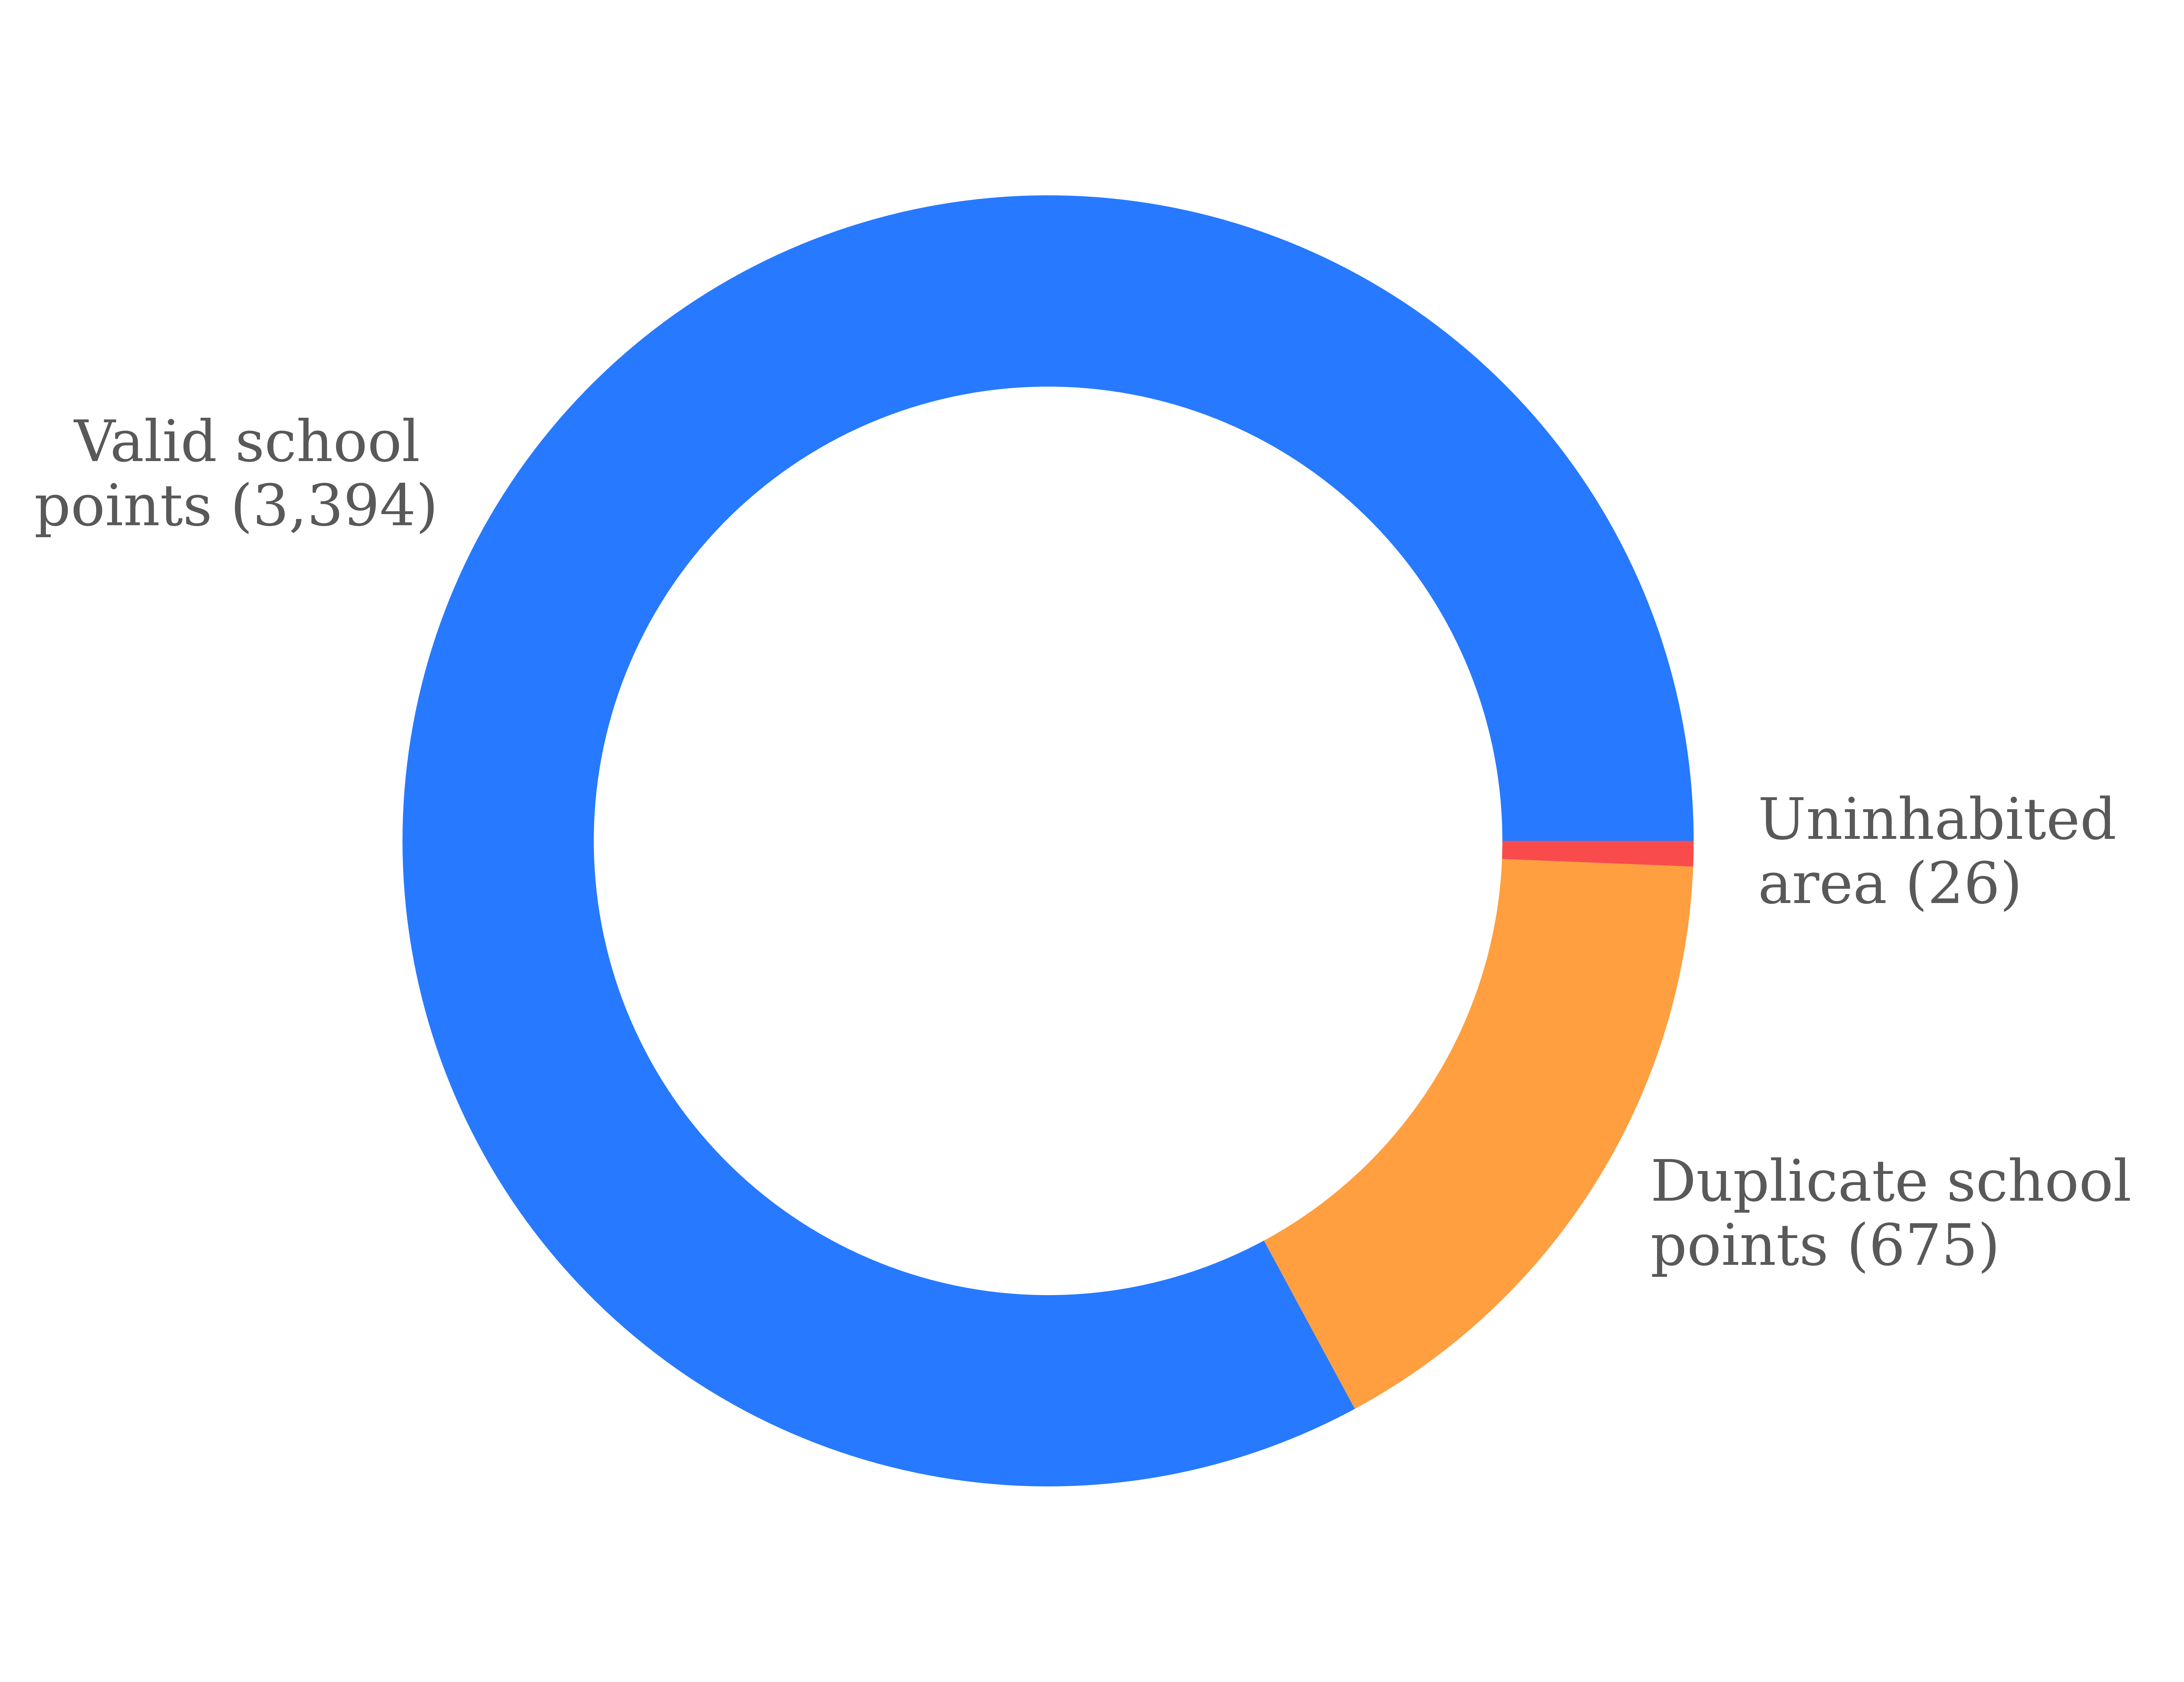

In [226]:
post_utils.donut_chart(master, source="master", legend=False)

INFO:root:(719, 16), (719, 15)


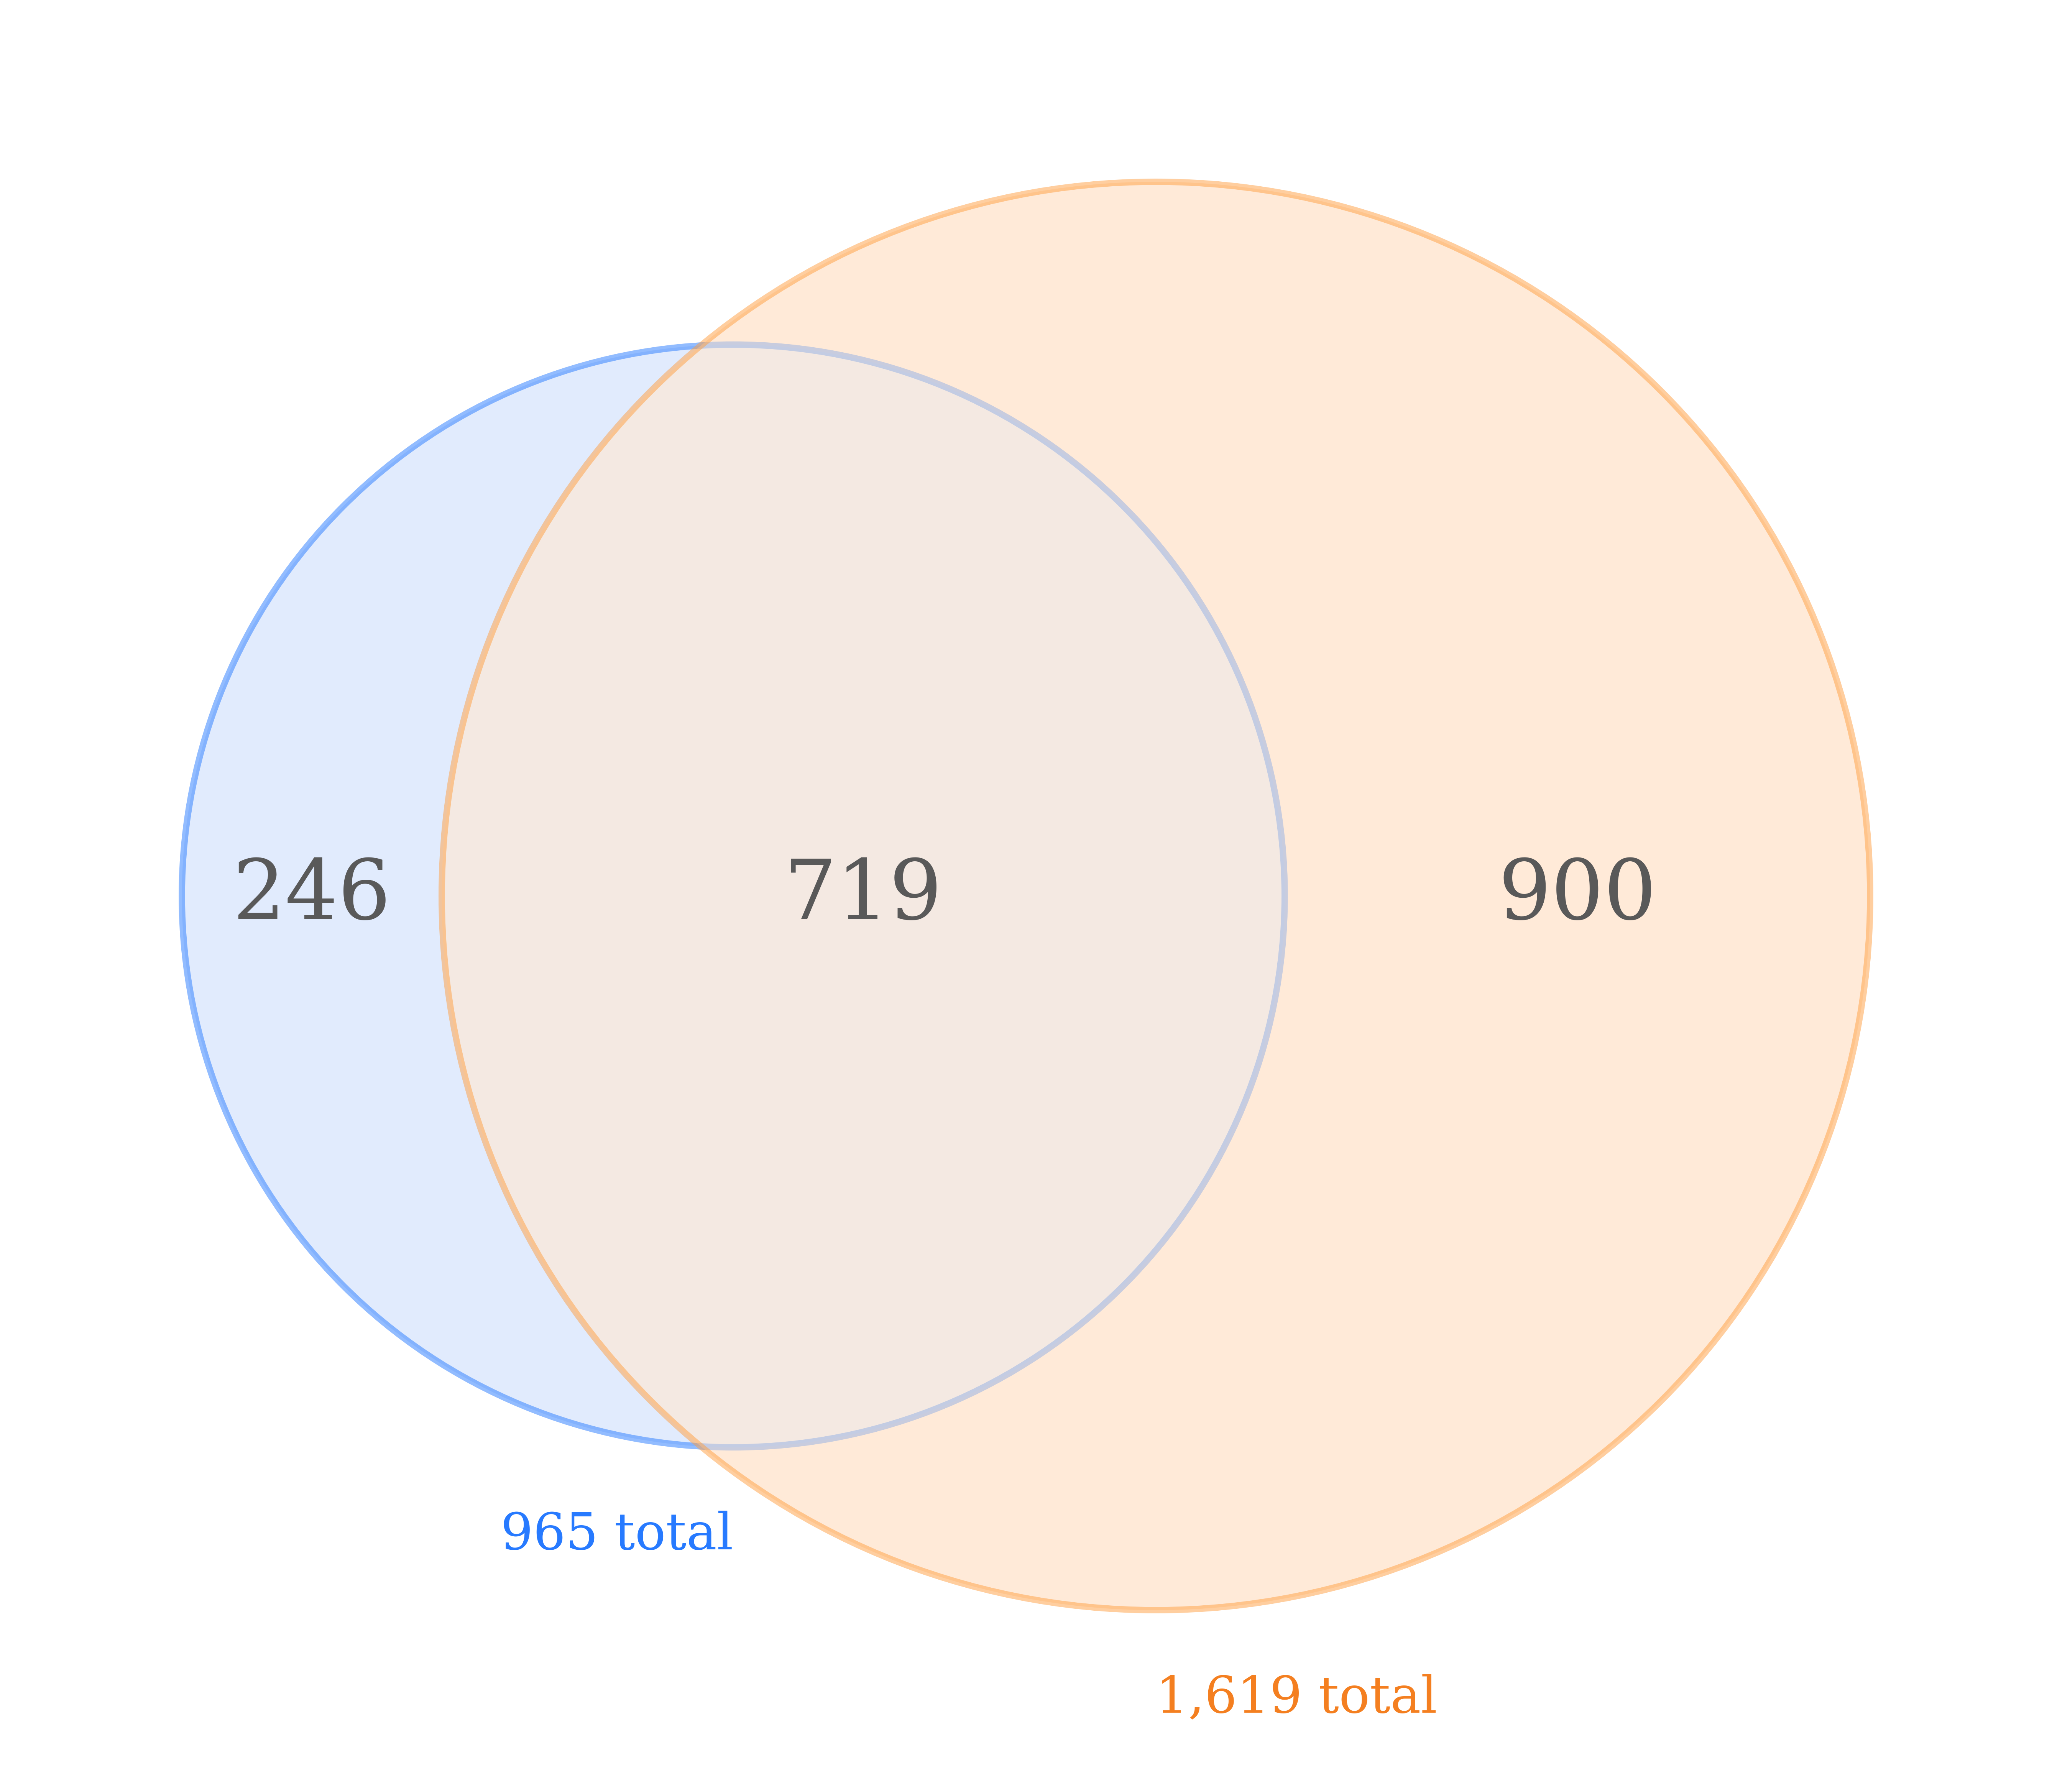

In [241]:
post_utils.venn_diagram(master, preds, threshold_dist=300, labels=False)

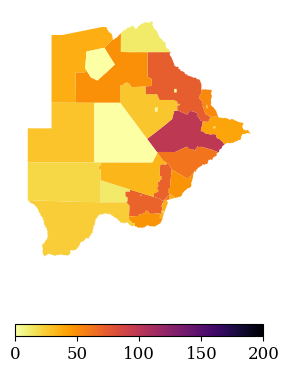

In [247]:
geoboundaries = post_utils.join_with_geoboundaries(
    master, preds, data_config, iso_code, threshold_dist=300, adm_level="ADM2"
)
vmax = np.max([np.nanmax(geoboundaries.master_n_points.values), np.nanmax(geoboundaries.preds_n_points.values)])
post_utils.plot_choropleth(geoboundaries, column="master_n_points", cmap='inferno_r', shrink=0.5, vmin=0, vmax=200)

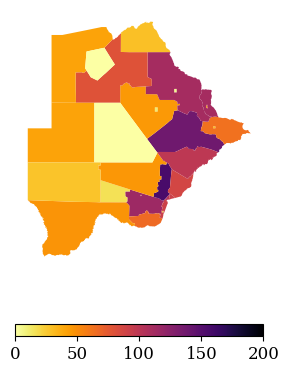

In [245]:
post_utils.plot_choropleth(geoboundaries, column="preds_n_points", cmap='inferno_r', shrink=0.5, vmin=0, vmax=200)

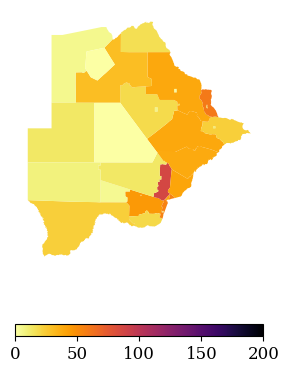

In [246]:
post_utils.plot_choropleth(geoboundaries, column="diff", cmap='inferno_r', shrink=0.5, vmin=0, vmax=200)